In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing, metrics, model_selection

In [ ]:
USE_GPU = True

dtype = torch.float # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [ ]:
train_mean = 0.0
train_std = 0.0

In [ ]:
nan_cache = {}
def data_preprocess(filename,mode='Train'):
  data = pd.read_csv(filename)
  if mode == 'Train':
    # split data to train, validation and test datsets
    train_data, val_data = model_selection.train_test_split(data,test_size = 0.2)
    means = train_data.mean() # to use mean or other indicators to fillna?
    train_data = train_data.fillna(means)
    val_data = val_data.fillna(means)
    for column in data:
      nan_cache[column] = means
    train_y = train_data.pop('unit_price')
    val_y = val_data.pop('unit_price')
    return train_data, val_data, train_y, val_y
  elif mode == 'Test':
    real_test_data = data.fillna(nan_cache)
    return real_test_data

In [ ]:
FILE = '/content/drive/MyDrive/SC201_Final_Project/Data/final_data_0830.csv' # your file path

In [ ]:
train_data, val_data, train_y, val_y = data_preprocess(FILE,mode='Train')
print(train_data.shape)
print(val_data.shape)

(22140, 90)
(5536, 90)


In [ ]:
# standardize data
train_mean = 207710.376
train_std = 79157.365
to_drop = ['lat','lng','lat_lng','unit_berth_price','compartmented','management_committee','floors_area','establishment','clothing_store','home_goods_store','store','local_government_office','university','natural_feature','health','tourist_attraction','transit_station','food']
for drop_items in to_drop:
  train_data.pop(drop_items)
  val_data.pop(drop_items)

print(train_data.columns)
print(val_data.shape)

Index(['zoning', 'total_floors', 'room', 'hall', 'bathroom',
       'total_berth_price', 'main_building_area', 'auxiliary_building_area',
       'balcony_area', 'elevator', 'building_age', 'travel_agency',
       'point_of_interest', 'transaction_first_floor', 'shifting_level',
       'villages_towns_Sanxia', 'villages_towns_Sanzhi',
       'villages_towns_Sanchong', 'villages_towns_Zhonghe',
       'villages_towns_Zhongshan', 'villages_towns_Zhongzheng',
       'villages_towns_Wugu', 'villages_towns_Xinyi', 'villages_towns_Neihu',
       'villages_towns_Bali', 'villages_towns_Beitou',
       'villages_towns_Nangang', 'villages_towns_Tucheng',
       'villages_towns_Shilin', 'villages_towns_Datong', 'villages_towns_Daan',
       'villages_towns_Wenshan', 'villages_towns_Xindian',
       'villages_towns_Xinzhuang', 'villages_towns_Songshan',
       'villages_towns_Banqiao', 'villages_towns_Linkou',
       'villages_towns_Shulin', 'villages_towns_Yonghe',
       'villages_towns_Xizhi', '

In [ ]:
# load images to dictionary
def load_imgs(lat_lng):
  image = Image.open('/content/drive/MyDrive/SC201_Final_Project/images/map/{}.png'.format(lat_lng)).convert('RGB')
  image = T.ToTensor()(image)
  return image

In [ ]:
class HousingDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,labels):
    self.y_train = torch.tensor(labels.values,dtype=torch.float32).view(len(labels),1)
    self.x_train = torch.tensor(dataset.values,dtype=torch.float32)
    print("HousingDataset shape {}, {}".format(self.x_train.shape, self.y_train.shape))
  def __len__(self):
    return len(self.y_train)
  def __getitem__(self,idx):
    return self.x_train[idx], self.y_train[idx]

In [ ]:
# Datasets load training examples one at a time, so we wrap each Dataset in a 
# DataLoader which iterates through the Dataset and forms minibatches. We divide
# the training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
# This is for after map data is loaded into the features, so shuffling is done
BATCH_SIZE = 32
def form_minibatch(data,mode='Train'):
  if mode == 'Train':
    data = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True)
  elif mode == 'Test':
    data = DataLoader(data,batch_size=BATCH_SIZE)
  return data

train_dl = form_minibatch(HousingDataset(train_data,train_y))
eval_dl = form_minibatch(HousingDataset(val_data,val_y),mode='Test')
print("training size {}, eval size {}".format(len(train_dl), len(eval_dl)))

HousingDataset shape torch.Size([22140, 72]), torch.Size([22140, 1])
HousingDataset shape torch.Size([5536, 72]), torch.Size([5536, 1])
training size 692, eval size 173


In [ ]:
# model = MyModel()
class MyModel(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.nn = nn.Sequential(
        nn.Linear(input_size, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.BatchNorm1d(15),
        nn.ReLU(),
        nn.Linear(15, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        nn.Linear(8, 1),
        )
        # epoch 25-29
        


    def forward(self,x1):
        x1 = self.nn(x1)
        return x1

net = MyModel(72)
optimizer = torch.optim.Adam(net.parameters(),lr=1e-5,weight_decay=0.99)
optimizer_SGD_momentum = torch.optim.SGD(net.parameters(),lr=1e-5,momentum=0.9,weight_decay=0.98)

In [ ]:
loss_history=[]
val_loss=[]
def train(data1, data2, model, optimizer, epochs=1):
    """
    Train a model on real estate data property features 
    and extracte map features using the PyTorch Module API.
    
    Inputs:
    - data1: training data
    - data2: validation data
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    criterion = nn.L1Loss()
    for e in range(epochs):
        running_loss = 0.0
        for t, (x1,y) in enumerate(data1):
            model.train()  # put model to training mode
            x1 = x1.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            scores = model(x1)

            loss = criterion(scores,y)
            running_loss += loss.item()
            loss_history.append(loss)

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % 100 == 0:
                training_loss = running_loss/len(data1)
                print('Iteration %d, loss = %.4f' % (t, training_loss))
                print('Checking accuracy on validation set')
                eval_loss, eval_l1_loss = check_accuracy(data2, model)
                print("Epoch {}, Eval loss: {}, l1 loss: {}".format(e, eval_loss, eval_l1_loss))


In [ ]:
def check_accuracy(data, model):
    criterion = nn.L1Loss() 
    total_loss = 0.0
    total_l1_loss = 0.0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
      for x1,y in data:
        x1 = x1.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=dtype)
        scores = model(x1)
        loss = criterion(scores,y)
        total_loss += loss.item()
        ground_truth_price = y * train_std + train_mean
        predicted_price = scores * train_std + train_mean
        total_l1_loss += abs(ground_truth_price - predicted_price)
      val_loss.append(total_l1_loss.data[0][0]/len(data))
      return total_loss/len(data), total_l1_loss.data[0][0]/len(data)

In [ ]:
train(train_dl, eval_dl, net,optimizer,epochs=28)

Iteration 0, loss = 0.0011
Checking accuracy on validation set
Epoch 0, Eval loss: 0.8116461052370898, l1 loss: 67472.9140625
Iteration 100, loss = 0.1201
Checking accuracy on validation set
Epoch 0, Eval loss: 0.821385210304591, l1 loss: 66879.984375
Iteration 200, loss = 0.2381
Checking accuracy on validation set
Epoch 0, Eval loss: 0.8102455223571359, l1 loss: 65308.55859375
Iteration 300, loss = 0.3538
Checking accuracy on validation set
Epoch 0, Eval loss: 0.7937152139368774, l1 loss: 64839.4609375
Iteration 400, loss = 0.4687
Checking accuracy on validation set
Epoch 0, Eval loss: 0.7944781042936909, l1 loss: 64818.54296875
Iteration 500, loss = 0.5794
Checking accuracy on validation set
Epoch 0, Eval loss: 0.7628230352622236, l1 loss: 61839.8984375
Iteration 600, loss = 0.6924
Checking accuracy on validation set
Epoch 0, Eval loss: 0.7645687988038697, l1 loss: 62123.16796875
Iteration 0, loss = 0.0009
Checking accuracy on validation set
Epoch 1, Eval loss: 0.7476180612696388, l1

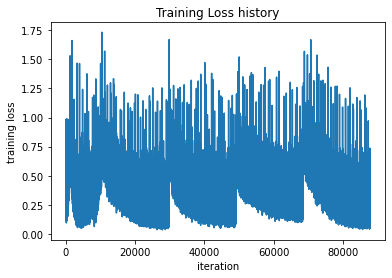

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_history)),loss_history)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

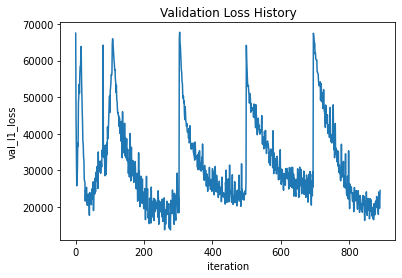

In [ ]:
plt.plot(range(len(val_loss)),val_loss)
plt.xlabel('iteration')
plt.ylabel('val_l1_loss')
plt.title('Validation Loss History')
plt.show()